# Visualize Heat Flux Damping (CESM1-LE)

Visualize Heat Flux Damping from CESM1-LE to illustrate the insignificance of the estimates in different ensemble members.

Uses the netcdf output from hfdamping_mat2nc.py

Written Jan 14 2022

In [45]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean
import sys
from tqdm.notebook import trange, tqdm

# Interactive Plotting
import hvplot.xarray
import panel as pn
import panel.widgets as pnw


In [30]:
# Import my modules
sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/")
sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/")

from amv import proc,viz
import scm

import importlib
importlib.reload(viz)

<module 'amv.viz' from '/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/viz.py'>

In [202]:
# User Edits

# Paths, Names
datpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/01_hfdamping/01_Data/"
figpath = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/01_hfdamping/02_Figures/20210114/"
ncname  = "CESM1-LE_NHFLX_Damping_raw.nc"
proc.makedir(figpath)

# Significance Test Parameters
dof     = 82       # Degrees of Freedom for Significaxnce Testing
p       = 0.20     # p-value
tails   = 2        # two-tailed or one-tailed test...

# Plotting Parameters
bboxplot =  [-80,0,5,60]
months   = [viz.return_mon_label(m+1,nletters='all') for m in range(12)]
print(months)

/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/01_hfdamping/02_Figures/20210114/ was found!
['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [11]:
%%time

# Load in the files as a dataset
ds = xr.open_dataset(datpath+ncname)

# Optionally load in the numpy arrays
damping = ds.nhflx_damping.values     # Damping [ens x lag x mon x lat x lon]
rflx    = ds.sst_flx_crosscorr.values
rsst    = ds.sst_autocorr.values
lon     = ds.longitude.values
lat     = ds.latitude.values
mon     = ds.month.values
ens     = ds.ensemble.values
lag     = ds.lag_month.values

CPU times: user 6.38 s, sys: 1.05 s, total: 7.43 s
Wall time: 7.49 s


In [12]:
ds

<xarray.Dataset>
Dimensions:            (ensemble: 42, lag_month: 3, month: 12, latitude: 192, longitude: 288)
Coordinates:
  * ensemble           (ensemble) int64 1 2 3 4 5 6 7 8 ... 36 37 38 39 40 41 42
  * lag_month          (lag_month) int64 1 2 3
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude           (latitude) float64 -90.0 -89.06 -88.12 ... 89.06 90.0
  * longitude          (longitude) float64 0.0 1.25 2.5 ... 356.2 357.5 358.8
Data variables:
    nhflx_damping      (ensemble, lag_month, month, latitude, longitude) float64 ...
    sst_flx_crosscorr  (ensemble, lag_month, month, latitude, longitude) float64 ...
    sst_autocorr       (ensemble, lag_month, month, latitude, longitude) float64 ...

In [17]:
# Make some interactive visualizations

slider = pnw.IntSlider(name='month', start=1, end=12)
ds.nhflx_damping.isel(ensemble=0,lag_month=0).interactive().isel(month=slider).hvplot(cmap="cmo.balance")



In [20]:
# Make a small animation
dsplot = ds.nhflx_damping.isel(ensemble=0,lag_month=0)

atime = pnw.Player(name='month', start=0, end=11, loop_policy='loop', interval=300)
dsplot.interactive(loc='bottom').isel(month=atime).hvplot(cmap='cmo.balance')

# Perform Significance Testing


In [203]:
# Calculate critical threshold

rhocrit = proc.ttest_rho(p,tails,dof)
print("The critical rho value is %f" % rhocrit)

The critical rho value is 0.141243


(<matplotlib.collections.QuadMesh at 0x7f89041a5590>,
 <matplotlib.colorbar.Colorbar at 0x7f893528e9d0>)

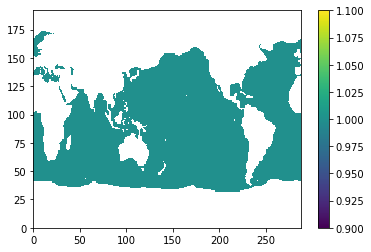

In [204]:
# Make land mask
limask = np.ones((192,288))
limask[np.isnan((np.sum(damping,(0,1,2))))] = np.nan
plt.pcolormesh(limask),plt.colorbar()

In [205]:
# Make the masks
msst = rsst > rhocrit
mflx = rflx > rhocrit
mall = msst * mflx 

msst.shape,mflx.shape

((42, 3, 12, 192, 288), (42, 3, 12, 192, 288))

In [206]:
def plot_hfdamping(e,plotlag,plotmon,lon,lat,damping,msk,ax=None,cints=None):
    
    if cints is None:
        cints = np.arange(-50,55,5)
    if ax is None:
        ax = plt.gca()
    
    # Select what to plot
    plotvar = damping[e,plotlag,plotmon,:,:]
    plotmsk = msk[e,plotlag,plotmon,:,:]
    
    # Flip Longitude
    lon1,plotvar1 = proc.lon360to180(lon,plotvar.T)
    _,plotmsk1    = proc.lon360to180(lon,plotmsk.T)
    
    # Plot the contours
    pcm = ax.contourf(lon1,lat,plotvar1.T,levels=cints,cmap='cmo.balance',extend='both')
    
    # Plot significant points
    viz.plot_mask(lon1,lat,plotmsk1,reverse=False,ax=ax,markersize=.75,color='gray')
    
    return ax,pcm

In [ ]:
%%time
# Make 42-ensemble plots
plotlag = 0
plotmon = 0


for m in range(12):
    plotmon=m
    fig,axs = plt.subplots(7,6,figsize=(16,16),facecolor='white',
                           subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
    cints = np.arange(-50,55,5)
    for e in tqdm(range(42)):

        ax = axs.flatten()[e]
        ax.coastlines()
        ax.set_extent(bboxplot)

        plotvar = damping[e,plotlag,plotmon,:,:]
        plotmsk = mall[e,plotlag,plotmon,:,:]

        # Flip Longitude
        lon1,plotvar1 = proc.lon360to180(lon,plotvar.T)
        _,plotmsk1    = proc.lon360to180(lon,(plotmsk*limask).T)
        #_,plotmsk1    = proc.lon360to180(lon,limask.T)

        pcm = ax.contourf(lon1,lat,plotvar1.T,levels=cints,cmap='cmo.balance',extend='both')


        # Plot significant points
        viz.plot_mask(lon1,lat,plotmsk1,reverse=False,ax=ax,markersize=.55,color='gray')

        # Add Subplot Labels
        ax = viz.label_sp(e+1,ax=ax,labelstyle="Ens%s",alpha=0.75,usenumber=True)
    fig.colorbar(pcm,ax=axs.flatten(),orientation='horizontal',fraction=0.025,pad=0.01)
    plt.suptitle("%s Lag %i Net Heat Flux Feedback ($Wm^{-2}K^{-1}$)" % (months[plotmon],plotlag+1),y=0.90,fontsize=16)
    plt.savefig("%sNHFLX_Damping_CESM1LE_mall_month%02i_lag%i.png" % (figpath,plotmon+1,plotlag+1),
                dpi=200,bbox_inches='tight',transparent=False)

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

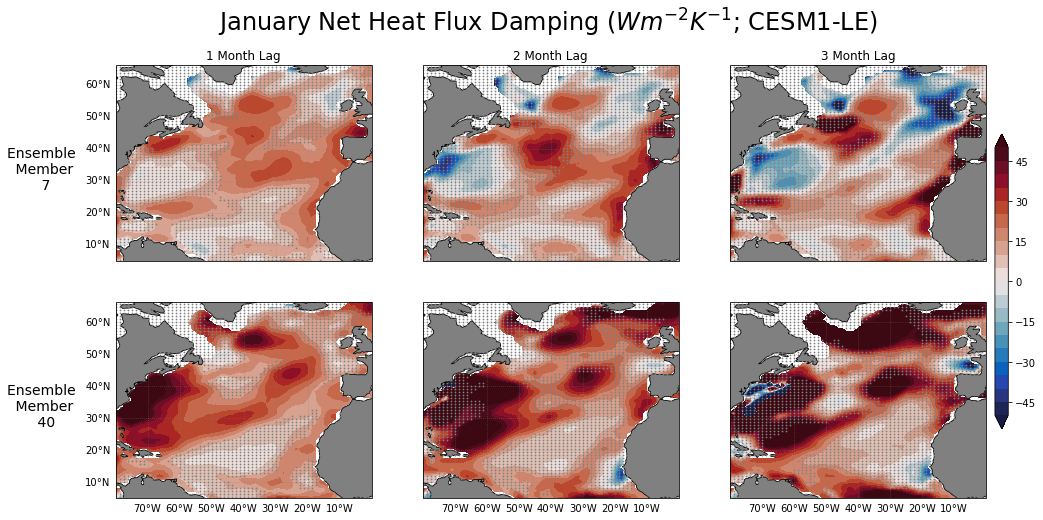

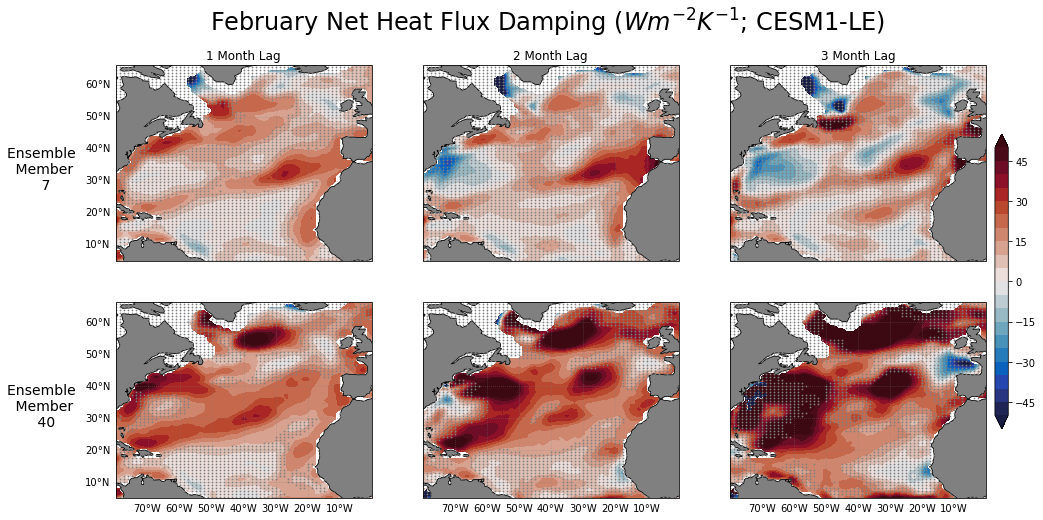

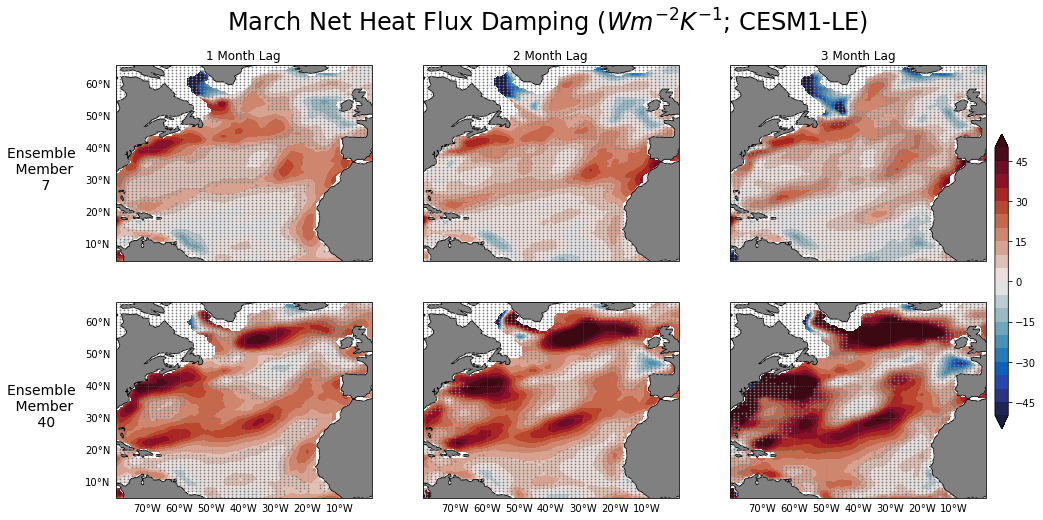

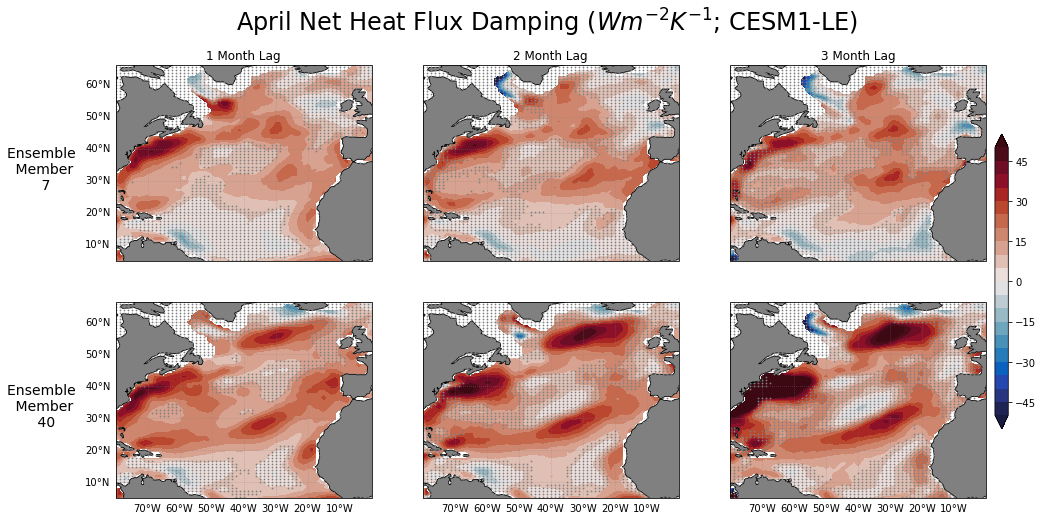

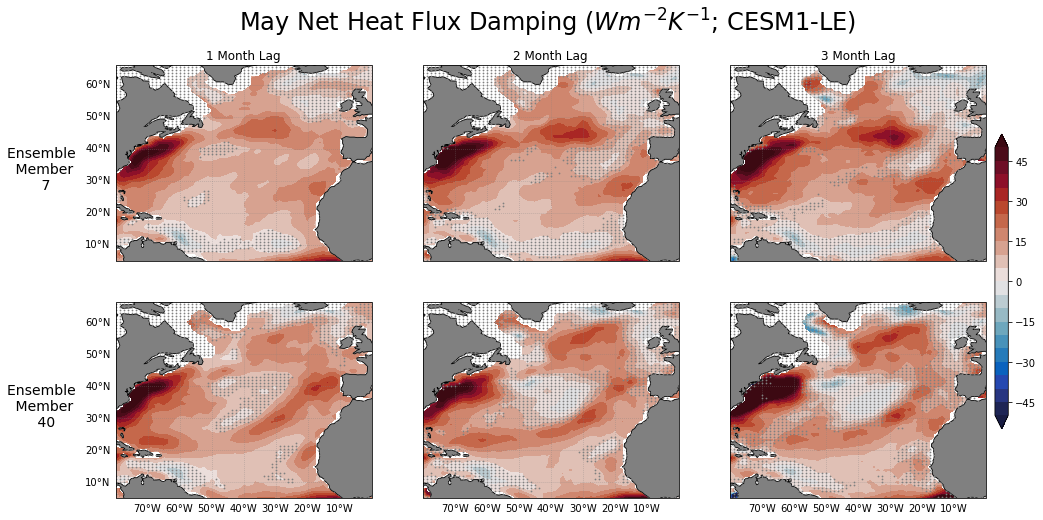

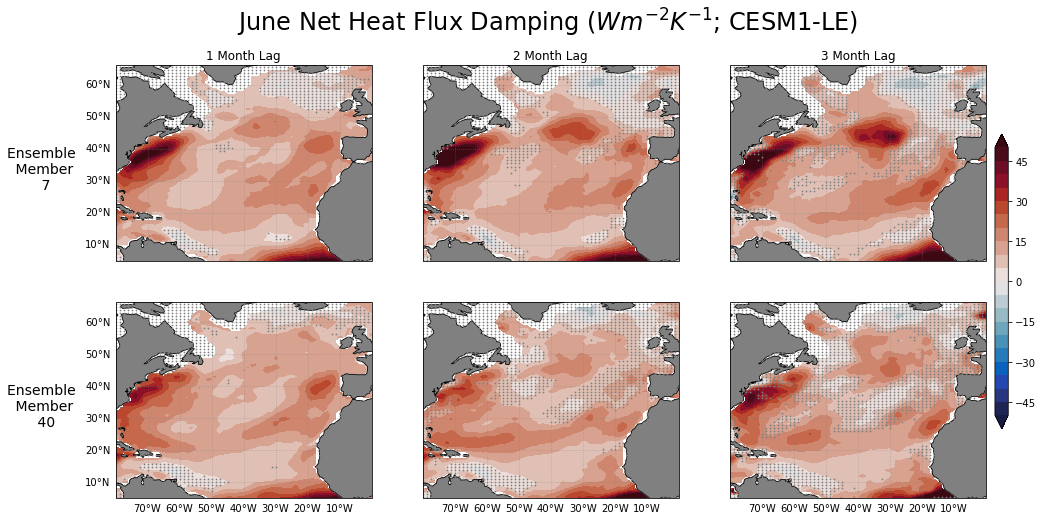

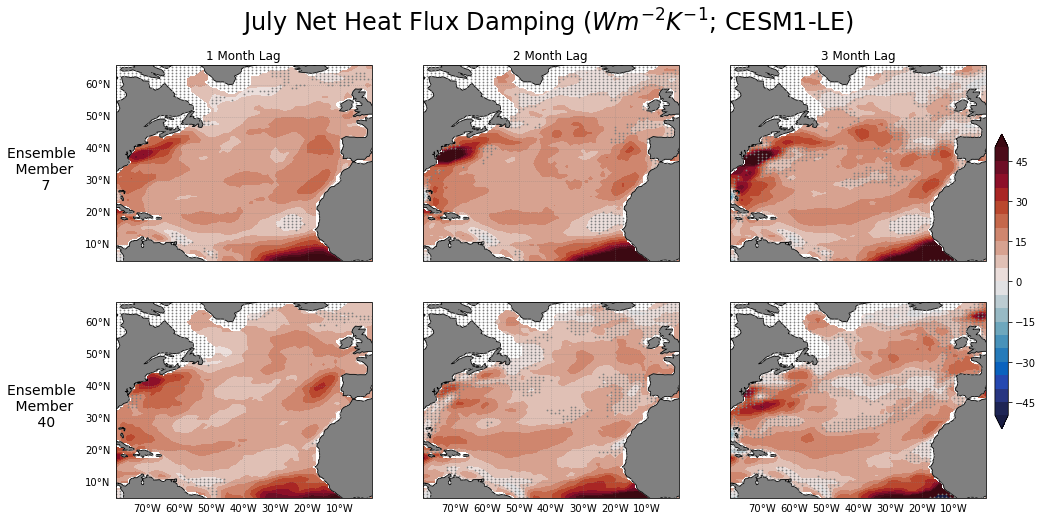

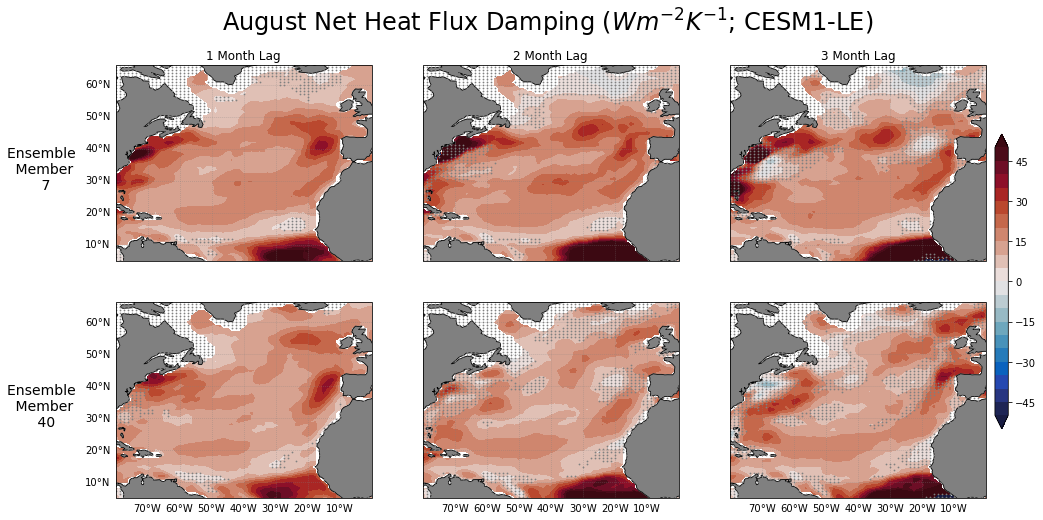

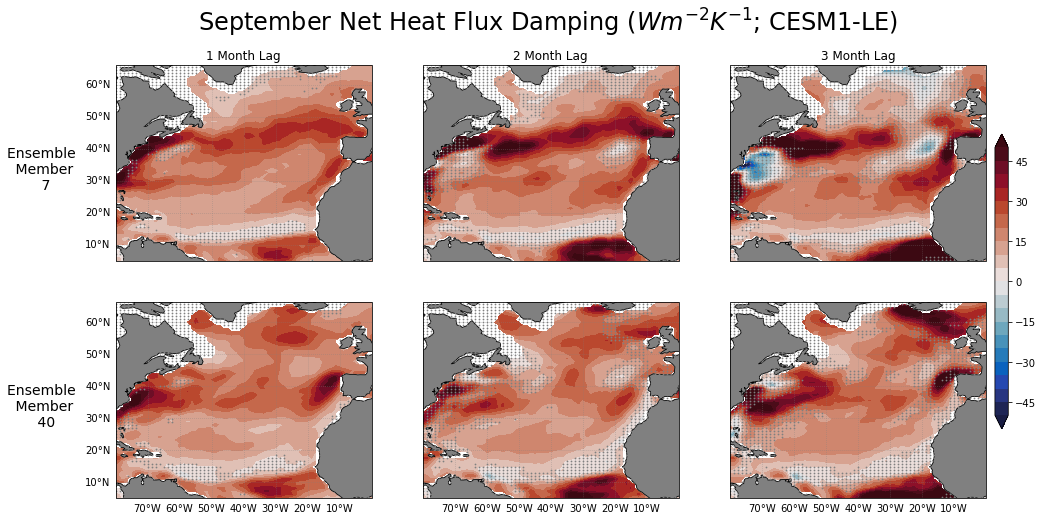

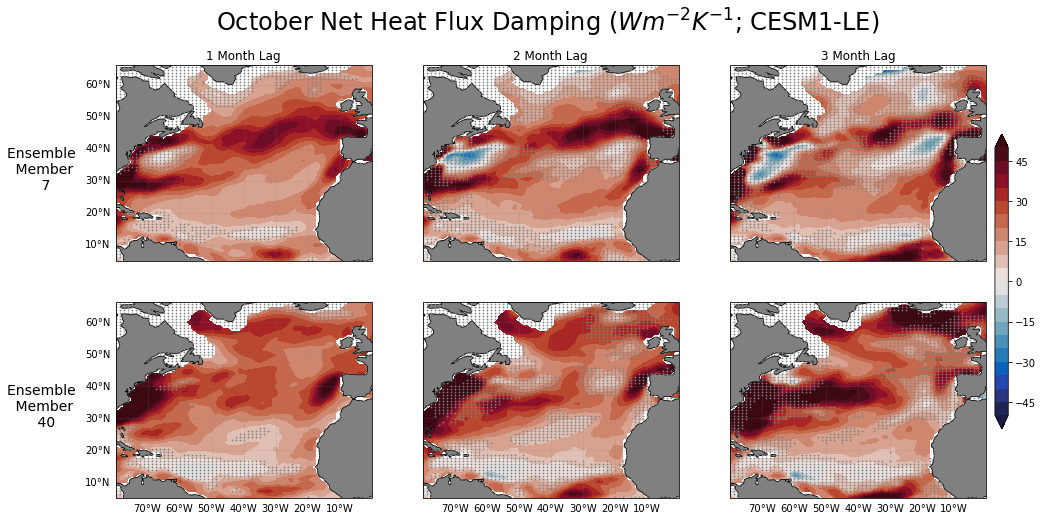

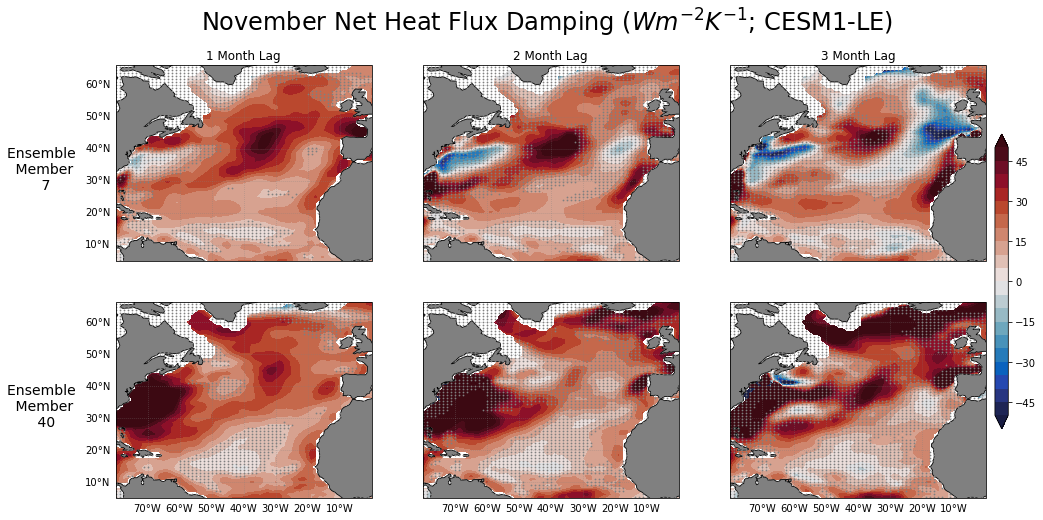

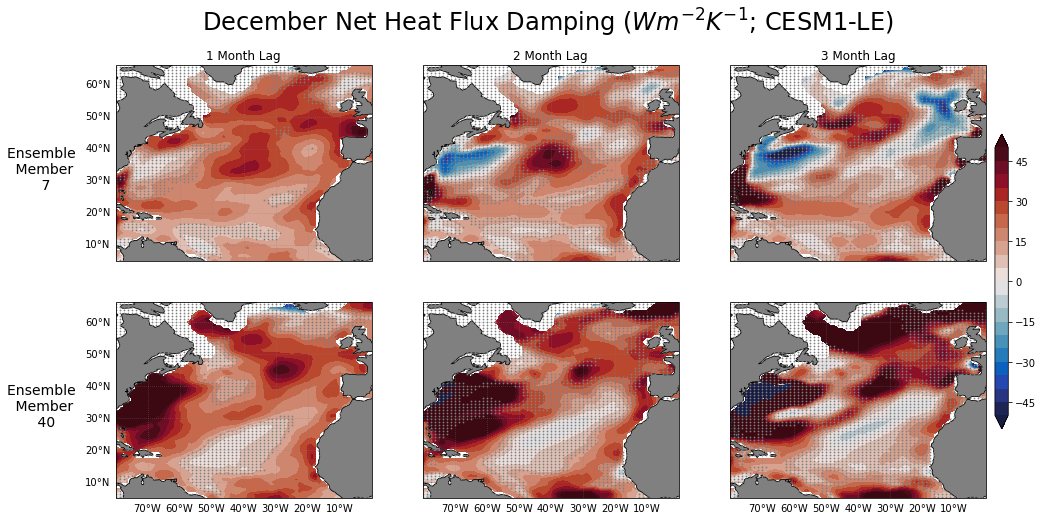

In [213]:
# Compare 2 different ensemble members
e1 = 6
e2 = 39
m  = 6
plotone = False

for m in tqdm(range(12)):
    
    
    
    fig,axs = plt.subplots(2,3,figsize=(16,8),facecolor='white',
                           subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
    for i,e in enumerate([e1,e2]):
        for l in range(3):  
            ax     = axs[i,l]
            blabel = [0,0,0,0]
            if i == 0: # Set title for first row
                ax.set_title("%i Month Lag" % (l+1))
            if l == 0: # Set labels for left 
                blabel[0]  = 1
                ax.text(-0.28, 0.35, 'Ensemble \n Member \n %i' % (e+1), va='bottom', ha='center',
                    rotation='horizontal', rotation_mode='anchor',
                    transform=ax.transAxes,fontsize=14)
            if i == 1: # Set labels for bottom
                blabel[-1] = 1
            ax = viz.add_coast_grid(ax,bbox=bboxplot,blabels=blabel,fill_color='gray')
            ax,pcm = plot_hfdamping(e,l,m,lon,lat,damping,mall,ax=ax)
    fig.colorbar(pcm,ax=axs.flatten(),fraction=0.015,pad=0.01)
    plt.suptitle("%s Net Heat Flux Damping ($Wm^{-2}K^{-1}$; CESM1-LE)" % (months[m]),fontsize=24,y=.98)

    plt.savefig("%sNHFLX_Damping_CESM1LE_comparison_mall_month%02i.png" % (figpath,m+1)
                ,dpi=200,bbox_inches='tight',transparent=False)
    
    if plotone:
        break

Text(0.5, 1.0, 'Heat Flux - SST Cross Correlation')

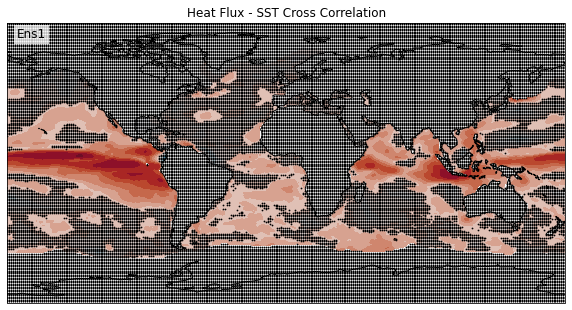

In [210]:
# Visualiz the mask (cross correlation)

fig,ax = plt.subplots(1,1,figsize=(10,8),
                       subplot_kw={'projection':ccrs.PlateCarree()})
cints = np.arange(-1,1.1,.1)

e = 0
plotlag = 2
plotmon = 0

ax.coastlines()
#ax.set_extent(bboxplot)

plotvar = rflx[e,plotlag,plotmon,:,:]
plotmsk = mflx[e,plotlag,plotmon,:,:]

# Flip Longitude
lon1,plotvar1 = proc.lon360to180(lon,plotvar.T)
_,plotmsk1    = proc.lon360to180(lon,plotmsk.T)
#_,plotmsk1    = proc.lon360to180(lon,limask.T)

pcm = ax.contourf(lon1,lat,plotvar1.T,levels=cints,cmap='cmo.balance',extend='both')


# Plot significant points
viz.plot_mask(lon1,lat,plotmsk1,reverse=False,ax=ax,markersize=.75)

# Add Subplot Labels
ax = viz.label_sp(e+1,ax=ax,labelstyle="Ens%s",alpha=0.75,usenumber=True)
ax.set_title("Heat Flux - SST Cross Correlation")



Text(0.5, 1.0, 'SST Auto Correlation')

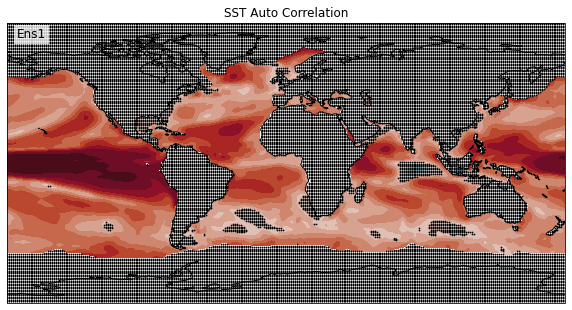

In [211]:
# Visualiz the mask (auto correlation)

fig,ax = plt.subplots(1,1,figsize=(10,8),
                       subplot_kw={'projection':ccrs.PlateCarree()})
cints = np.arange(-1,1.1,.1)

e = 0
plotlag = 2
plotmon = 0

ax.coastlines()
#ax.set_extent(bboxplot)

plotvar = rsst[e,plotlag,plotmon,:,:]
plotmsk = msst[e,plotlag,plotmon,:,:]

# Flip Longitude
lon1,plotvar1 = proc.lon360to180(lon,plotvar.T)
_,plotmsk1    = proc.lon360to180(lon,plotmsk.T)
#_,plotmsk1    = proc.lon360to180(lon,limask.T)

pcm = ax.contourf(lon1,lat,plotvar1.T,levels=cints,cmap='cmo.balance',extend='both')


# Plot significant points
viz.plot_mask(lon1,lat,plotmsk1,reverse=False,ax=ax,markersize=.75)

# Add Subplot Labels
ax = viz.label_sp(e+1,ax=ax,labelstyle="Ens%s",alpha=0.75,usenumber=True)
ax.set_title("SST Auto Correlation")



In [101]:
lon

array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
        10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
        20.  ,  21.25,  22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,
        30.  ,  31.25,  32.5 ,  33.75,  35.  ,  36.25,  37.5 ,  38.75,
        40.  ,  41.25,  42.5 ,  43.75,  45.  ,  46.25,  47.5 ,  48.75,
        50.  ,  51.25,  52.5 ,  53.75,  55.  ,  56.25,  57.5 ,  58.75,
        60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,  67.5 ,  68.75,
        70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,  78.75,
        80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
        90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75,
       100.  , 101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75,
       110.  , 111.25, 112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75,
       120.  , 121.25, 122.5 , 123.75, 125.  , 126.25, 127.5 , 128.75,
       130.  , 131.25, 132.5 , 133.75, 135.  , 136.25, 137.5 , 138.75,
      